In [2]:
# Bibliotecas de uso general en el cuaderno
import numpy as np
from myutils import *
import pickle
import os
from matching.games import HospitalResident


In [3]:
path = '../GeoData/Instances/Instance_0.pkl'

with open(path, 'rb') as f:
    instance = pickle.load(f) 
    f.close()

In [4]:
for k in instance.keys():
    exec(f"{k} = instance['{k}']")

# Proceso de asignación

En este cuaderno se mustra un ejemplo de los procesos de asignación propuestos. El proceso de asignación consiste en determinar qué base atenderá a cada foco te atención. Para poder realizar la asignación en este problema, se necesitan tener la siguiente información:

* matriz de costos `costs`: en donde cada fila representa una base y cada columna un punto de demanda, el valor que contiene en cada celda representa el costo de ir de la base $i$ al punto $j$. Esta matriz es de dimensiones $m\times n$.

* vector solución `z`: es un vector binario de $m$ elementos, en donde cada elemento representa una de las bases, y están marcadas con $1$ todas aquellas que están disponibles en esa solución y con $0$ las que no. En un proceso de búsqueda este vector puede contener bases disponibles que al final del proceso de asignación descartadas, por lo que el proceso de asignación también es un proceso de corrección.

* vector de capacidades `cap`: es un vector de $m$ elementos en donde el elemento $i$ correpsonde a la base $i$ (el mismo elemento en el vector solución) y contiene la capacidad de cada base, es decir, cuántas ambulancias puede almacenar. Por conveniencia, está escalado al número mínimo de ambulancias indispensables por base, es decir, si una base puede acontener 6 ambulancias, pero se define que una base puede cubrir un punto de demanda con mínimo 3 ambulancias, entonces la capacidad en escala sería de 2, ya que sólo puede atender a 2 puntos de demanda.

El resultado del proceso de asignación son dos variables:

* vector solución corregido `z_r`: el vector binario en donde se marca únicamente las bases que cubren a un punto de demanda, puede tener igual o menor cantidad de $1$ que `z`.

* vector de asignación `a`: vector de enteros de $n$ elementos, en donde cada uno representa un punto de demanda y contiene el índice de la base que lo cubre, es decir, puede ir de $0$ a $m-1$.

La mayoría de procesos de asignación consideran en algún momento la base más cercana, por lo que el primer paso consiste en encontrar las bases más cercanas disponibles a cada punto de demanda. EN este cuaderno se ejemplifican los diferentes procesos de asignación con un ejemplo pequeño, en donde se considera una matríz de costos `costs` con 7 bases y 5 puntos de demanda (`m=7`,`n=5`), y una solución en donde sólo hay 3 bases disponibles para asignar (`z=[1,0,1,0,1,0,1]`). El vector de capacidades `cap` se propondrá posteriormente. 

In [5]:
costs = np.array([  [ 4,87, 6,10,42],
                    [12, 2,32,43,51],
                    [ 5,47, 3,82, 1],
                    [31,12,37,41,25],
                    [52, 4,31,22,11],
                    [16,89,54,67,45],
                    [99,98,97,96,95]])

z = [1,0,1,0,1,0,1]

## Asignación al más cercano disponible

En el primer tipo de asignación se ordenan las bases para cada punto de demanda y se asignan a la base más cercana, sin embarrgo, dado que tienen una capacidad límite, se descartan las bases ocupadas. Esto significa que sí afecta el orden en el que se asignan las bases a los puntos de demanda ya que este define cuáles puntos de demanda son atendidos por su base más cercana y cuáles deben optar por la segunda, tercera, cuarta, etc. Por conveniencia se asignan según su posición en la matriz de costos.

In [6]:
# Indices de las bases marcadas con 1
indices_bases = np.nonzero(z*1)[0]  

# Para cada punto de demanda (columna) ordenar las bases por costo,
# es decir, mueve las filas, arriba las bases menos costosas por cada punto de demanda
columnas = np.argsort(costs[indices_bases], axis = 0)

# Obtener las bases más cercanas a cada colapso
nearest_base = indices_bases[columnas]

print('-'*10, 'Costos', '-'*10)
print(costs)
print('-'*10, 'Indices de las bases disponibles', '-'*10)
print(indices_bases)
print('-'*10, 'Costos de las bases disponibles', '-'*10)
print(costs[indices_bases])
print('-'*10, 'índices relativos de las bases ordenadas por costo', '-'*10)
print(columnas)
print('-'*10, 'indices absolutos de las bases ordenadas por costo', '-'*10)
print(nearest_base)



---------- Costos ----------
[[ 4 87  6 10 42]
 [12  2 32 43 51]
 [ 5 47  3 82  1]
 [31 12 37 41 25]
 [52  4 31 22 11]
 [16 89 54 67 45]
 [99 98 97 96 95]]
---------- Indices de las bases disponibles ----------
[0 2 4 6]
---------- Costos de las bases disponibles ----------
[[ 4 87  6 10 42]
 [ 5 47  3 82  1]
 [52  4 31 22 11]
 [99 98 97 96 95]]
---------- índices relativos de las bases ordenadas por costo ----------
[[0 2 1 0 1]
 [1 1 0 2 2]
 [2 0 2 1 0]
 [3 3 3 3 3]]
---------- indices absolutos de las bases ordenadas por costo ----------
[[0 4 2 0 2]
 [2 2 0 4 4]
 [4 0 4 2 0]
 [6 6 6 6 6]]


Con la matriz de costos `mat` y la matriz resultante `nearest` (última matriz mostrada), se puede observar que para el primer punto de demanda (columna `[0,2,4]`), las bases disponibles se encuentran en orden de cercanía, la base 0 está a 4 unidades, la base 2 a 5 unidades y la base 4 a 52 unidades. Por otro lado, para el segundo punto de demanda (columna `[4,2,0]`), la base 4 está a 4 unidades, la base 2 está a 47 unidades y la base 0 está a 87 unidades. Con esto se comprueba que el primer procedimiento es correcto y que ahora se sabe cuál de las bases disponibles en el vector $z$ está más cerca de cada punto de demanda y el resto de bases están ordenadas de la más cercana a la más lejana. Este orden de la base màs cercana a la màs lejana tambièn se puede interpretar como una lsita de preferencia, en donde cada punto de demanda prefiere a las bases màs cercanas en ese orden.

Para esta asignación, consideremos un vector de capacidades `cap = [1,2,2,5,2,3,4]`, nótese que esto representa que la base con índice $0$ puede atender a 1 punto de demanda, la base $1$ a $2$ y así sicesivamente... La capacidad real en número de ambulancias sería `[3,6,6,15,6,9,12]`

In [7]:
# Defnie las capacidades de las bases
cap1 = [1,2,2,5,2,3,4]

a1 = [-1 for _ in range(costs.shape[1])]

Este tipo de asignación consiste en tomar los puntos de demanda en un orden arbitrario o aleatorio y asignarlos a la base más cercana; conforme las bases se van ocupando, los puntos van siendo asignados a su segunda base más cercana, tercera, cuarta, etc, por lo que no se garantiza una asignación óptima.

El caso ideal en el que todos los puntos de demanda pueden ser cubiertos por su base más cercana (la primera en su lista de preferencia) sería que el vector de asignación `a1` tomara el valor de la primera fila de la matriz `nearest`, es decir: `[0,4,2,0,2]`; sin embargo, se observa que en el vector de capacidades, la base $0$ sólo puede atender a un punto de demanda, que es el $0$, el punto de demanda $3$ es asignado a la base $4$ y el resto sí son cubiertos por su base más cercana.

In [8]:
# Por cada punto de demanda, identifica la más cercana disponible
for j in range(nearest_base.shape[1]):
    
    # Recorre las bases (columnas)
    for i in range(nearest_base.shape[0]):
        
        # Si la base en la posición [j] tiene capacidad para atender el punto i, 
        # se asigna y se descuenta del vector de capacidades
        if cap1[nearest_base[i][j]] > 0:
            cap1[nearest_base[i][j]] -= 1
            a1[j] = nearest_base[i][j]
            
            # Se procede al siguiente punto de demanda
            break
        
        # Si no hay capacidad, se procede a la siguiente base
        else:
            continue
    
    # Si no se pudo asignar ninguna base, se termina el ciclo con error
    if a1[j] == -1:
        print('Error, no hay bases disponibles para atender el punto de demanda', j)
        break

# Vector de solución reparado:
z1 = np.zeros(costs.shape[0])
z1[a1] = 1

print('-'*10, 'Asignación de colapsos a bases', '-'*10)
print('a1 = ',a1)
print('-'*10, 'Capacidades restantes de las bases', '-'*10)
print('cap = ',cap1)
print('-'*10, 'Solución reparada', '-'*10)
print('z1 = ',z1)

---------- Asignación de colapsos a bases ----------
a1 =  [0, 4, 2, 4, 2]
---------- Capacidades restantes de las bases ----------
cap =  [0, 2, 0, 5, 0, 3, 4]
---------- Solución reparada ----------
z1 =  [1. 0. 1. 0. 1. 0. 0.]


In [9]:
a = np.zeros(5)
a[[1,2,1]] = 1

Finalmente, se puede observar que en el proceso de asignación, no todas las bases disponibles del vector Z fueron asignadas, por lo que también se reparó y se obtuvo `z1`.

## Asignación por nivel de prioridad

Una propuesta realizada por Ghoseiri y Ghannadpour es determinar el orden de asignación por nivel de prioridad, en lugar de ser un orden arbitrario o aleatorio. Una forma de calcular las prioridades es con la diferencia entre la segunda base más cercana y la primera, por lo que el procedimiento requiere un paso extra de ordenamiento

In [10]:
# Obtiene la matriz de costos ordenada por costo por cada punto de demanda
# a diferencia de la otra matriz, no contiene el ìndice si no el valor
nearest_base_value = np.sort(costs[indices_bases], axis=0)

# Calculas las prioridades de los puntos de demanda
priorities = nearest_base_value[1] - nearest_base_value[0]

new_indices = np.argsort(priorities)[::-1]

In [11]:
cap2 = [1,2,2,5,2,3,4]

a2 = [-1 for _ in range(costs.shape[1])]

In [12]:
# Por cada punto de demanda, identifica la más cercana disponible
for j in new_indices:
    
    # Recorre las bases (columnas)
    for i in range(nearest_base.shape[0]):
        
        # Si la base en la posición [j] tiene capacidad para atender el punto i, 
        # se asigna y se descuenta del vector de capacidades
        if cap2[nearest_base[i][j]] > 0:
            cap2[nearest_base[i][j]] -= 1
            a2[j] = nearest_base[i][j]
            
            # Se procede al siguiente punto de demanda
            break
        
        # Si no hay capacidad, se procede a la siguiente base
        else:
            continue
    
    # Si no se pudo asignar ninguna base, se termina el ciclo con error
    if a2[j] == -1:
        print('Error, no hay bases disponibles para atender el punto de demanda', j)
        break

# Vector de solución reparado:
z2 = np.zeros(costs.shape[0])
z2[a2] = 1

print('-'*10, 'Asignación de colapsos a bases', '-'*10)
print('a2 = ',a2)
print('-'*10, 'Capacidades restantes de las bases', '-'*10)
print('cap = ',cap2)
print('-'*10, 'Solución reparada', '-'*10)
print('z2 = ',z2)

---------- Asignación de colapsos a bases ----------
a2 =  [4, 4, 2, 0, 2]
---------- Capacidades restantes de las bases ----------
cap =  [0, 2, 0, 5, 0, 3, 4]
---------- Solución reparada ----------
z2 =  [1. 0. 1. 0. 1. 0. 0.]


## Asignación por emparejamiento estable
### Modelo Hospital-resitentes con capadidad

En el modelo de asignación anterior, se toma como factor ùnico la lista de preferencia de los puntos de demanda (columnas de la matriz `nearest`) . Por otro lado, el modelo de asignación por emparejamiento considera también una lista de preferencia por parte de las bases, la cuales prefieren cubrir a los puntos de demanda más cercanos. En este modelo se usa el algoritmo de Galey-Shapley modificado para crear un agrupamiento basado en preferencia mutua con capacidades limitadas.

En este ejmplo se define de nuevo la capacidad y un vector de asignación nuevo

In [13]:
# Defnie las capacidades de las bases
cap3 = [1,2,2,5,2,3,4]

a3 = [-1 for _ in range(costs.shape[1])]

Las preferencias de los puntos de demanda se pueden obtener de las columnas de la matriz `nearest`, y para las preferencias de las bases se obtienen las filas ordenadas de la matriz de costos con las bases disponibles. 

Para realizar el emparejamiento se usa la biblioteca "Matching", por lo que se definene las lsitas de preferencias y capacidades en términos de diccionarios, en donde las claves son los índices de las bases y los puntos de demanda en la matríz de costos.

In [14]:
# Para cada base (fila) ordenar los puntos de demanda por costo,
# es decir, mueve las columnas, a la izquierda los colapsos menos costosos por cada base
filas = np.argsort(costs[indices_bases], axis = 1)

# Obtener los colapsos más cercanos a cada base
nearest_point = filas

# Cada punto prefeire una base en este orden:
pref_points = dict([(i, col) for i,col in enumerate(nearest_base.T)])

# Cada base prefiere un punto en este orden:
pref_base = dict([(indices_bases[i], row) for i,row in enumerate(nearest_point)])

# Cada base tiene una capacidad
base_capacity = dict([(i, cap3[i]) for i in indices_bases])

Se crea el modelo Residente a partir de los diccionarios y se utiliza el mètodo solve. Del resultado se puede obtener el vector de asignación y en caso de haber, los puntos de demanda no emparejados (no cubiertos por ninguna base)

In [15]:
game = HospitalResident.create_from_dictionaries(
    pref_points, pref_base, base_capacity
)

solution = game.solve(optimal="resident")
print(solution)

{0: [0], 2: [4, 2], 4: [1, 3], 6: []}


In [16]:
# llena el vector de asignación
for b in solution.keys():
    for p in solution[b]:
        a3[p.name] = b.name
        cap3[b.name] -= 1

# Identifica los colapsos no asignados
matched = [i.name for j in solution.values() for i in j]
unmatched = set(range(costs.shape[1])) - set(matched)

# Vector de solución reparado:
z3 = np.zeros(costs.shape[0])
z3[a3] = 1

print('-'*10, 'Asignación de colapsos a bases', '-'*10)
print('a3 = ',a3)
print('-'*10, 'Capacidades restantes de las bases', '-'*10)
print('cap = ',cap3)
print('-'*10, 'Solución reparada', '-'*10)
print('z3 = ',z3)

---------- Asignación de colapsos a bases ----------
a3 =  [0, 4, 2, 4, 2]
---------- Capacidades restantes de las bases ----------
cap =  [0, 2, 0, 5, 0, 3, 4]
---------- Solución reparada ----------
z3 =  [1. 0. 1. 0. 1. 0. 0.]


# Prueba en escenario real

Se implementa la función de asignacióncon parámetros: matríz de costos, vector de capacidades, vector de solución y tipo de asignación. Se prueba su funcionamiento con un conjunto de puntos aleatorios en el espaico euclideo y en una instancia del problema de optimización.

In [813]:
def assign(costs, capacities, demands, sol, type='classic'):
    
    cap = capacities.copy()
    dem = demands.copy()
    z = copy(sol)
    # Indices de las bases marcadas con 1
    indices_bases = np.nonzero(z*1)[0]  

    # Para cada punto de demanda (columna) ordenar las bases por costo,
    # es decir, mueve las filas, arriba las bases menos costosas por cada punto de demanda
    columnas = np.argsort(costs[indices_bases], axis = 0)

    # Obtener las bases más cercanas a cada colapso
    nearest_base = indices_bases[columnas]
    
    a = [-1 for _ in range(costs.shape[1])]
    
    if type == 'classic':
        
        # Por cada punto de demanda, identifica la más cercana disponible
        for j in range(nearest_base.shape[1]):
            
            # Recorre las bases (columnas)
            for i in range(nearest_base.shape[0]):
                
                # Si la base en la posición [j] tiene capacidad para atender el punto i, 
                # se asigna y se descuenta del vector de capacidades
                if cap[nearest_base[i][j]] >= dem[j]:
                    cap[nearest_base[i][j]] -= dem[j]
                    a[j] = nearest_base[i][j]
                    
                    # Se procede al siguiente punto de demanda
                    break
                
                # Si no hay capacidad, se procede a la siguiente base
                else:
                    continue
        
            '''
            # Si no se pudo asignar ninguna base, se termina el ciclo con error
            if a[j] == -1:
                print('Error, no hay bases disponibles para atender el punto de demanda', j)
                return -1
            '''
           
        
    elif type == 'urgencies':
        
        # Obtiene la matriz de costos ordenada por costo por cada punto de demanda
        # a diferencia de la otra matriz, no contiene el ìndice si no el valor
        nearest_base_value = np.sort(costs[indices_bases], axis=0)

        # Calculas las prioridades de los puntos de demanda
        priorities = nearest_base_value[1] - nearest_base_value[0]

        new_indices = np.argsort(priorities)[::-1]
        
        # Por cada punto de demanda, identifica la más cercana disponible
        for j in new_indices:
            
            # Recorre las bases (columnas)
            for i in range(nearest_base.shape[0]):
                
                # Si la base en la posición [j] tiene capacidad para atender el punto i, 
                # se asigna y se descuenta del vector de capacidades
                if cap[nearest_base[i][j]] >= dem[j]:
                    cap[nearest_base[i][j]] -= dem[j]
                    a[j] = nearest_base[i][j]
                    
                    # Se procede al siguiente punto de demanda
                    break
                
                # Si no hay capacidad, se procede a la siguiente base
                else:
                    continue
            
            '''
            # Si no se pudo asignar ninguna base, se termina el ciclo con error
            if a[j] == -1:
                print('Error, no hay bases disponibles para atender el punto de demanda', j)
                return -1
            '''
    
    elif type == 'urgencies_cap':
        
        # Obtiene la matriz de costos ordenada por costo por cada punto de demanda
        # a diferencia de la otra matriz, no contiene el ìndice si no el valor
        nearest_base_value = np.sort(costs[indices_bases], axis=0)

        # Calculas las prioridades de los puntos de demanda
        priorities = nearest_base_value[1] - nearest_base_value[0]

    
        
        new_indices = np.argsort(dem)[::-1]
        
        new_indices = np.lexsort((priorities, dem))[::-1]

        
        # Por cada punto de demanda, identifica la más cercana disponible
        for j in new_indices:
            
            # Recorre las bases (columnas)
            for i in range(nearest_base.shape[0]):
                
                # Si la base en la posición [j] tiene capacidad para atender el punto i, 
                # se asigna y se descuenta del vector de capacidades
                if cap[nearest_base[i][j]] >= dem[j]:
                    cap[nearest_base[i][j]] -= dem[j]
                    a[j] = nearest_base[i][j]
                    
                    # Se procede al siguiente punto de demanda
                    break
                
                # Si no hay capacidad, se procede a la siguiente base
                else:
                    continue
            
            '''
            # Si no se pudo asignar ninguna base, se termina el ciclo con error
            if a[j] == -1:
                print('Error, no hay bases disponibles para atender el punto de demanda', j)
                return -1
            '''
        
    
    c = 0

    # Verifica que todos los puntos de demanda hayan sido asignados
    for point, base in enumerate(a):
        
        # Si para un punto de demanda no se asignó base, se habilita la base
        # más cercana disponible
        
        if base == -1:
            
            bases_to_point = costs[:,point]
            nearest_base = np.argsort(bases_to_point)
            
            for b in nearest_base:
                if cap[b] >= dem[point]:
                    cap[b] -= dem[point]
                    a[point] = b
                    z[b] = 1
                    break
           
        c += costs[base, point]
    
    # Vector de solución reparado:
    z = np.zeros(costs.shape[0])
    z[a] = 1
    
    return a, z, round(c,2)
        

In [844]:
# 6649151895
rndGen = np.random.default_rng(seed=6649151895)

bases = rndGen.uniform(0, 10, size=(2000, 2))

destinos = rndGen.uniform(0, 10, size=(14, 2))

costs = np.zeros((bases.shape[0], destinos.shape[0]))

for i in range(bases.shape[0]):
    for j in range(destinos.shape[0]):
        costs[i,j] = np.linalg.norm(bases[i] - destinos[j])

costs = costs.round(4)
capacities = rndGen.integers(1, 15, size=bases.shape[0])
demands = rndGen.integers(1, 5, size=costs.shape[1])

In [845]:
# 14787
rndGen = np.random.default_rng(seed=14787)
ind = rndGen.choice(bases.shape[0], size=7, replace=False)
z = np.zeros(costs.shape[0])
z[ind] = 1


In [846]:
a1, z1, c1 = assign(costs, capacities, demands, z, type='classic')
a2, z2, c2 = assign(costs, capacities, demands, z, type='urgencies')
a3, z3, c3 = assign(costs, capacities, demands, z, type='urgencies_cap')

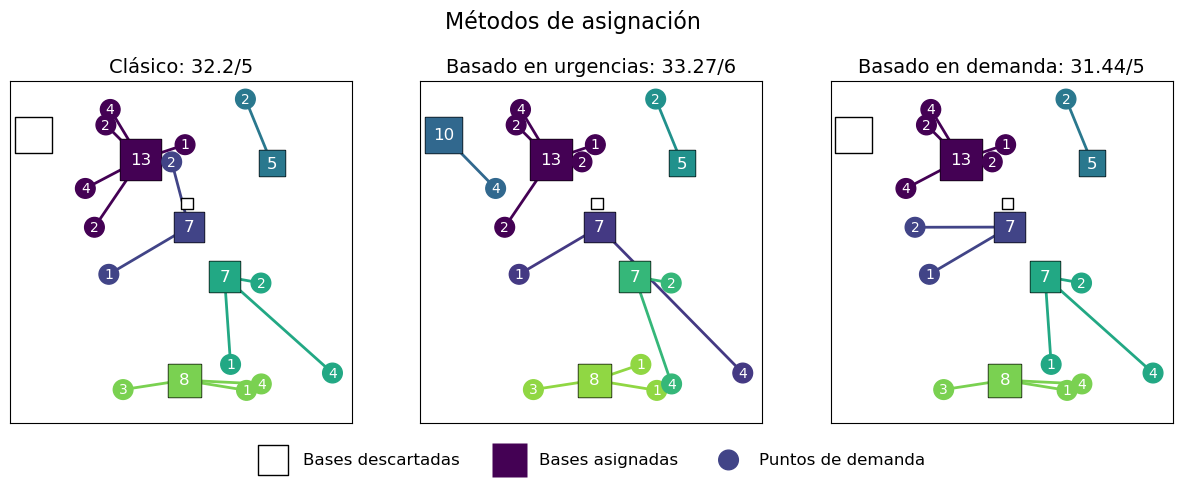

In [847]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, axes= plt.subplots(1, 3, figsize=(15,5))
fig.suptitle('Métodos de asignación', fontsize=16)
mult = 70
metodos = ['Clásico', 'Basado en urgencias', 'Basado en demanda']

for i, ax in enumerate(axes):

    # Bases asignadas
    ind_z = np.nonzero([z1, z2, z3][i])[0]
    
    # Vector de asignación
    a = [a1, a2, a3][i]
    
    # Colores
    cmap = mpl.colormaps['viridis']
    
    dict_color = dict([(ind_z[j], cmap(j/len(ind_z))) for j in range(len(ind_z))])
    # Espacio de búsuqeda completo
    #ax.scatter(bases[:,0], bases[:,1], marker='^', label='Bases', edgecolors='k', c='w', s=capacities, alpha=0.1)
    
    # Solución posible con las bases disponibles
    bd = ax.scatter(bases[ind,0], bases[ind,1], marker='s', label='z', 
                edgecolors='k', c='w', s=capacities[ind]*mult)

    # Solución reparada con la asignación
    base_color = [dict_color[ind_z[j]] for j in range(len(ind_z))]
    bs = ax.scatter(bases[ind_z,0], bases[ind_z,1], marker='s', label='z', 
                edgecolors=(0,0,0,0), color = base_color , s=capacities[ind_z]*mult, zorder = 1)

    # Puntos de demanda
    pd_color = [dict_color[a[j]] for j in range(len(a))]
    pd = ax.scatter(destinos[:,0], destinos[:,1], marker='o', label='Puntos de demanda', 
                color = pd_color, s = 200)

    # Texto de las capacidades
    for j,b in enumerate(bases[ind_z,:]):
        ax.text(b[0], b[1], capacities[ind_z[j]], fontsize=12, c='w', ha = 'center', va='center')
    
    # Texto de los puntos de demanda
    for j,d in enumerate(destinos):
        ax.text(d[0], d[1], demands[j], fontsize=10, c='w', ha = 'center', va='center', zorder = 3)
    
    # Líneas de conexión
    for point, base in enumerate([a1, a2, a3][i]):
        if point != -1:
            ax.plot([bases[base,0], destinos[point,0]], [bases[base,1], destinos[point,1]], '-',
                    c = dict_color[base], lw = 2, zorder = 0)
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax.set_xlim(-0.5, 10.5)
    ax.set_ylim(-0.5, 10.5)
    ax.set_aspect('equal')
            
    ax.title.set_text(metodos[i] + ': ' + str([c1, c2, c3][i]) + '/' + str(int(sum([z1, z2, z3][i]))))
    ax.title.set_fontsize(14)
    
    if i == 0:
        ax.legend([bd, bs, pd], ['Bases descartadas','Bases asignadas', 'Puntos de demanda'], 
                  loc=[0.7,-0.15], fontsize=12, framealpha=0, edgecolor='k', ncol=3)
    
    
    fig.savefig('../Figuras/Results/Allocation_1.svg')

In [848]:
print(ind_z)
print(a1)
print(dict_color)

[ 206  934 1276 1737 1747]
[934, 1747, 1276, 1747, 206, 1737, 1747, 1737, 206, 206, 206, 206, 934, 1737]
{206: (0.267004, 0.004874, 0.329415, 1.0), 934: (0.253935, 0.265254, 0.529983, 1.0), 1276: (0.163625, 0.471133, 0.558148, 1.0), 1737: (0.134692, 0.658636, 0.517649, 1.0), 1747: (0.477504, 0.821444, 0.318195, 1.0)}
